In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from utils.arch.anomalies import shock_mean_fn, shock_volatility_fn, perturbed_mean_fn, increasing_volatility_fn, constant_mean, extra_perturbed_mean_fn, double_volatility_fn, deterministic_volatility
from utils.simulate_markov import simulate_arch_1_process, simulate_arch1_process_with_dynamic_anomaly
from utils.markov_depth import calculate_markov_tukey_depth_for_trajectories_using_sample_trajectories, NADARAYA_WATSON, calculate_markov_tukey_depth_for_trajectories_using_long_trajectory
from utils.experiments.dd_plots import obtain_dd_plot
from scipy.stats import ranksums

# Homogeneity testing

In [2]:
# Set up the Seaborn style
sns.set(style="whitegrid")

In [3]:
# Fix the random seed for reproducibility 
random_seed = 7
np.random.seed(random_seed)

In [4]:
# Max Number of steps on each trajectory
n_steps = 200
min_n_steps = 50
# Number of steps of the initial long trajectory.
# Used for the initial kernel estimation.
n_steps_long = n_steps*5
# Number of trajectories to simulate in group X
M = 50
# Number of trajectories to simulate in group Y
A = 50

# Number of rank-sum tests to execute
NUM_ITERATIONS = 50

# Bandwidth parameter for the kernel estimation
inverse_bandwidth = np.power(n_steps_long, 1/5)

In [5]:
# Parameters of the ARCH(1) process (X)
INITIAL_VALUE = 0.5

def mean_fn(x):
    return 1 / (1 + np.exp(-x))

def volatility_fn(x):
    return norm.pdf(x + 1.2) + 1.5 * norm.pdf(x - 1.2)

In [6]:
# Parameters of the ARCH(1) process (X)
INITIAL_VALUE = 0.5

def mean_fn(x):
    return 1 / (1 + np.exp(-x))

def volatility_fn(x):
    return norm.pdf(x + 1.2) + 1.5 * norm.pdf(x - 1.2)

In [7]:
# Perturbed mean
def get_perturbed_mean_fn(alpha):
    def _perturbed_mean(x):
        return 1 / (1+alpha + np.exp(-x))
    return _perturbed_mean

In [8]:
# Simulate  the long trajectory that will be the reference population
random_seed +=1
long_trajectory = simulate_arch_1_process(
    n_steps=n_steps_long, 
    m=mean_fn, 
    sigma=volatility_fn, 
    initial_value=INITIAL_VALUE,
    num_processes=1, 
    seed=random_seed,
)[0]

In [9]:
alphas = np.linspace(0.3,1,num=15)
average_p_values = list()
for a in alphas:
    p_values = list()
    for i in range(NUM_ITERATIONS):
        # Simulate  ARCH(1) processes (X)
        random_seed +=1
        regular_trajectories = simulate_arch_1_process(
            n_steps=n_steps, 
            m=mean_fn, 
            sigma=volatility_fn, 
            initial_value=INITIAL_VALUE,
            num_processes=M, 
            min_n_step=min_n_steps,
            seed=random_seed,
        )

        random_seed +=1
        different_trajectories = simulate_arch_1_process(
            n_steps=n_steps, 
            m=get_perturbed_mean_fn(alpha=a), 
            sigma=volatility_fn, 
            initial_value=INITIAL_VALUE,
            num_processes=M, 
            min_n_step=min_n_steps,
            seed=random_seed,
        )
        all_trajectories = regular_trajectories+different_trajectories
        all_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=all_trajectories, long_trajectory=long_trajectory, marginal_cdf_estimator=NADARAYA_WATSON)
        regular_trajectories_depths = all_depths[:M] 
        different_trajectories_depths = all_depths[M:] 
        r = ranksums(regular_trajectories_depths, different_trajectories_depths)
        p_values.append(r.pvalue)
    average_p_values.append(np.mean(p_values))


In [10]:
average_p_values

[0.19241115693630703,
 0.17385890947496793,
 0.07795783690297799,
 0.04972507884804794,
 0.026305466144281118,
 0.005187550699275437,
 0.0022156506413458705,
 0.002398211719959378,
 0.00028661779704198745,
 0.0006282435978605177,
 1.640656662630379e-05,
 4.315005168444489e-06,
 2.144363666964651e-05,
 1.8759272787241869e-06,
 6.56969467497929e-08]

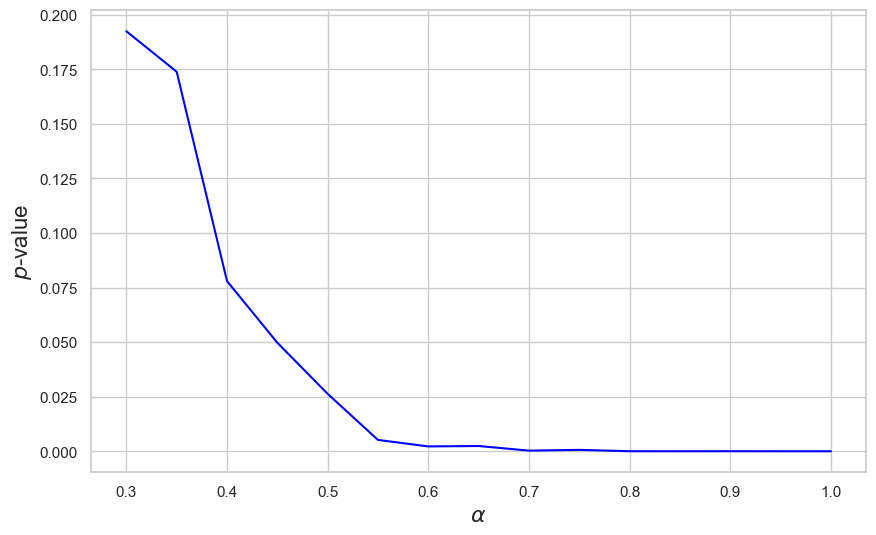

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, average_p_values, linestyle='-', color='blue', label='Average p-values')
plt.xlabel(r"$\alpha$", fontsize=16)
plt.ylabel(r"$p$-value", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
